<a href="https://colab.research.google.com/github/NicoPolazzi/kube-performance-predictor/blob/gnn/kpp/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-geometric

2.9.0+cu126
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3857040 sha256=4dd5dd49dbf03e3b4d9739c676712cb75336fe7a3e3a7b9c8627aa6136af52d4
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=3039798 sha256=2baae9bb7bd6fbe534edf3370515924912cc4d1a21d537fef7cc94e7414bdae3
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2


In [38]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import DenseGATConv

### Dataset Definition

In [47]:
NODE_ORDER = [
    'checkoutservice',
    'emailservice',
    'currencyservice',
    'paymentservice',
    'frontend',
    'cartservice',
    'adservice',
    'shippingservice',
    'recommendationservice',
    'productcatalogservice'
]

feature_cols = ['User Count', 'Response Time (s)', 'Throughput (req/s)', 'CPU Usage']


# Adjacency Matrix (Source -> Destination)
# 1 = Connection, 0 = No connection
ADJ_MATRIX = [
    # fr, ad, rec,cat,chk,crt,shp,cur,pay,eml
    [0,  1,  1,  1,  1,  1,  1,  1,  0,  0], # frontend
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # ad
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0], # recommendation
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # productcatalog
    [0,  0,  0,  1,  0,  1,  1,  1,  1,  1], # checkout
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # cart
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # shipping
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # currency
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # payment
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # email
]

# def get_static_edge_index():
#     """Converts the matrix to the format required by PyTorch Geometric, because we need an edge list"""
#     rows, cols = np.where(np.array(ADJ_MATRIX) == 1)
#     return torch.tensor([rows, cols], dtype=torch.long)

class MicroserviceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def prepare_data_robust(csv_path, window_size=10):
    df = pd.read_csv(csv_path)

    # Filter only relevant nodes and enforce categorical order
    df = df[df['Service'].isin(NODE_ORDER)]
    df['Service'] = pd.Categorical(df['Service'], categories=NODE_ORDER, ordered=True)

    # We create a grid of all (Timestamp x Service) combinations
    timestamps = sorted(df['Timestamp'].unique())
    full_idx = pd.MultiIndex.from_product(
        [timestamps, NODE_ORDER],
        names=['Timestamp', 'Service']
    )

    # Reindex ensures we have exactly T * N rows, sorted correctly
    df = df.set_index(['Timestamp', 'Service'])
    df = df.reindex(full_idx)

    # Fill missing rows with 0
    df = df[feature_cols].fillna(0)

    # 4. Extract and Reshape
    # df.values is now (Num_Timestamps * Num_Nodes, Num_Features)
    raw_data = df.values

    num_timestamps = len(timestamps)
    num_nodes = len(NODE_ORDER)
    num_features = len(feature_cols)

    # We must ensure the columns in pivot match NODE_ORDER.
    # (Implementation detail: Reindex columns to match NODE_ORDER before .values)

    data_3d = raw_data.reshape(num_timestamps, num_nodes, num_features)

    train_size = int(0.7 * num_timestamps)
    val_size = int(0.15 * num_timestamps)

    train_data = data_3d[:train_size]
    val_data = data_3d[train_size : train_size + val_size]
    test_data = data_3d[train_size + val_size :]

    scaler = MinMaxScaler(feature_range=(0,1))

    def process_split(data, is_train=False):
        # 1. Log Transform (Robustness)
        # Use log1p to handle zeros safely (log(0+1) = 0)
        data_log = np.log1p(data)

        # 2. Flatten for Scaler
        flat = data_log.reshape(-1, num_features)

        # 3. Scale
        if is_train:
            flat_scaled = scaler.fit_transform(flat)
        else:
            flat_scaled = scaler.transform(flat)

        # 4. Reshape back to (Time, Nodes, Features) and Tensor
        return torch.tensor(flat_scaled.reshape(data.shape), dtype=torch.float32)

    train_data = process_split(train_data, is_train=True)
    val_data = process_split(val_data, is_train=False)
    test_data = process_split(test_data, is_train=False)

    return train_data, val_data, test_data, scaler

def create_windows(data_tensor, window_size):
    # Sliding window function
    X, y = [], []
    for i in range(len(data_tensor) - window_size):
        X.append(data_tensor[i : i + window_size])
        y.append(data_tensor[i + window_size])
    return MicroserviceDataset(X, y)

### Model definition

In [36]:
class DenseGATLSTM(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, adj_matrix):
        super(DenseGATLSTM, self).__init__()
        self.num_nodes = num_nodes

        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)

        # Dense GAT: Expects inputs (Batch, Nodes, Features)
        self.gat = DenseGATConv(in_channels, hidden_channels, heads=4, concat=True)
        # Input to LSTM is the flattened output of the GAT for all nodes
        self.lstm = nn.LSTM(input_size=num_nodes * (4* hidden_channels),
                            hidden_size=64,
                            batch_first=True)

        # Prediction Head: Maps back to original feature space
        self.fc = nn.Linear(64, num_nodes * out_channels)

    def forward(self, x_seq):
        # x_seq shape: (Batch, Window, Nodes, Features)
        batch_size, window_size, nodes, feats = x_seq.size()
        adj_batch = self.adj.unsqueeze(0).repeat(batch_size, 1, 1).to(x_seq.device)

        spatial_embeddings = []
        for t in range(window_size):
            xt = x_seq[:, t, :, :] # Shape: (Batch, Nodes, Features)

            # Vectorized GAT pass
            # Output: (Batch, Nodes, Hidden * Heads)
            gat_out = self.gat(xt, adj_batch)

            # Flatten nodes for LSTM: (Batch, Nodes * Hidden_Total)
            spatial_embeddings.append(gat_out.view(batch_size, -1))

        # Stack time sequence: (Batch, Window_Size, Nodes * Hidden)
        lstm_input = torch.stack(spatial_embeddings, dim=1)
        lstm_out, _ = self.lstm(lstm_input)

        # Take the output of the last time step
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        # Reshape to (Batch, Nodes, Features)
        return out.view(batch_size, nodes, -1)

### Configuration

In [51]:
csv_path = "/content/drive/MyDrive/kube-performance-predictor/performance_results.csv"

# Hyperparameters
WINDOW_SIZE = 10
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_tensor, val_tensor, test_tensor, scaler = prepare_data_robust(csv_path)
train_dataset = create_windows(train_tensor, WINDOW_SIZE)
val_dataset = create_windows(val_tensor, WINDOW_SIZE)
test_dataset = create_windows(test_tensor, WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Using device: cuda
Data Split: Train=482, Val=95, Test=96


### Training

Starting training...
Epoch 5/100 | Train Loss: 0.161974 | Val Loss: 0.348086 -> Saved Best Model
Epoch 10/100 | Train Loss: 0.044578 | Val Loss: 0.213536 -> Saved Best Model
Epoch 15/100 | Train Loss: 0.028022 | Val Loss: 0.187345 -> Saved Best Model
Epoch 20/100 | Train Loss: 0.020802 | Val Loss: 0.177310 -> Saved Best Model
Epoch 25/100 | Train Loss: 0.016885 | Val Loss: 0.175799 
Epoch 30/100 | Train Loss: 0.014722 | Val Loss: 0.170663 
Epoch 35/100 | Train Loss: 0.013886 | Val Loss: 0.169141 
Epoch 40/100 | Train Loss: 0.013354 | Val Loss: 0.168408 
Epoch 45/100 | Train Loss: 0.013235 | Val Loss: 0.168278 
Epoch 50/100 | Train Loss: 0.012884 | Val Loss: 0.167123 
Epoch 55/100 | Train Loss: 0.012567 | Val Loss: 0.166684 
Epoch 60/100 | Train Loss: 0.012647 | Val Loss: 0.167058 
Epoch 65/100 | Train Loss: 0.012098 | Val Loss: 0.163153 -> Saved Best Model
Epoch 70/100 | Train Loss: 0.012130 | Val Loss: 0.164850 
Epoch 75/100 | Train Loss: 0.011734 | Val Loss: 0.163723 
Epoch 80/100 | 

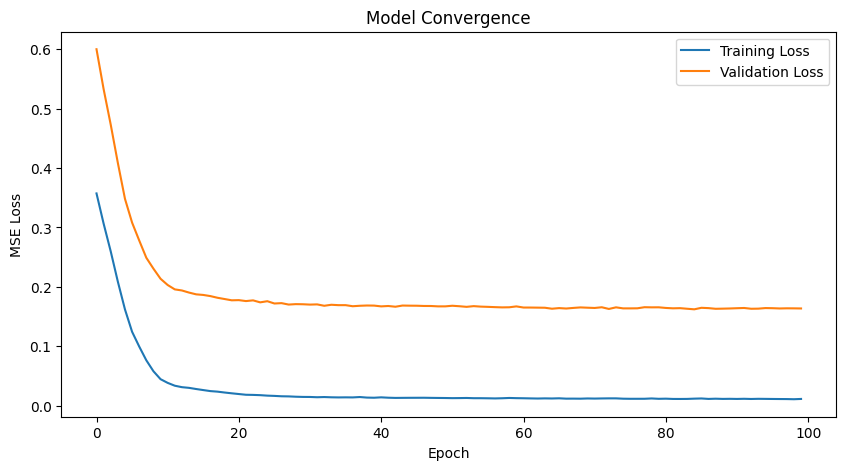


Evaluating on Test Set...
Final Test MSE Loss: 0.598711


In [52]:
features_count = 4

model = DenseGATLSTM(
    num_nodes=len(NODE_ORDER),
    in_channels=features_count,        # [User, Resp, Thru, CPU]
    hidden_channels=16,   # Dimension of graph embedding
    out_channels=features_count,       # Output features to predict
    adj_matrix= ADJ_MATRIX
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# We use L1Loss (MAE) for better robustness against outliers
criterion = nn.L1Loss()

print("Starting training...")
start_time = time.time()

loss_history = []

best_val_loss = float('inf')
train_history = []
val_history = []

for epoch in range(EPOCHS):
    # A. Training Phase
    model.train()
    total_train_loss = 0
    for x_seq, y_true in train_loader:
        x_seq, y_true = x_seq.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_history.append(avg_train_loss)

    # B. Validation Phase (No Gradient)
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            v_loss = criterion(val_pred, y_val)
            total_val_loss += v_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_history.append(avg_val_loss)

    # C. Checkpointing (Save Best Model)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_dense_gat_lstm.pth')
        saved_msg = "-> Saved Best Model"
    else:
        saved_msg = ""

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} {saved_msg}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training finished in {total_time:.2f} seconds ({total_time/EPOCHS:.2f}s/epoch).")

plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title("Model Convergence")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


# Test Phase
print("\nEvaluating on Test Set...")

# Load the best state
model.load_state_dict(torch.load('best_model_dense_gat_lstm.pth'))
model.eval() # Set to evaluation mode (disables dropout, etc.)

total_test_loss = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Predict
        y_pred = model(x_test)

        loss = criterion(y_pred, y_test)
        total_test_loss += loss.item()

print(f"Final Test MSE Loss: {total_test_loss / len(test_loader):.6f}")

### Testing inference

In [54]:
def inspect_inference(model, loader, scaler, node_names, target_node='frontend'):
    """
    Runs inference, Inverse Scales, and Inverse Logs (expm1) to get real units.
    """
    model.eval()

    x, y_true_scaled = next(iter(loader))
    x, y_true_scaled = x.to(device), y_true_scaled.to(device)

    with torch.no_grad():
        y_pred_scaled = model(x)

    y_pred_np = y_pred_scaled.cpu().numpy()
    y_true_np = y_true_scaled.cpu().numpy()

    y_pred_np = np.maximum(0, y_pred_np)

    batch_size, num_nodes, num_features = y_pred_np.shape


    y_pred_flat = y_pred_np.reshape(-1, num_features)
    y_true_flat = y_true_np.reshape(-1, num_features)

    y_pred_log = scaler.inverse_transform(y_pred_flat)
    y_true_log = scaler.inverse_transform(y_true_flat)

    # np.expm1 is the mathematical inverse of np.log1p
    y_pred_real_flat = np.expm1(y_pred_log)
    y_true_real_flat = np.expm1(y_true_log)

    # 3. Reshape back to 3D
    y_pred_real = y_pred_real_flat.reshape(batch_size, num_nodes, num_features)
    y_true_real = y_true_real_flat.reshape(batch_size, num_nodes, num_features)

    if target_node in node_names:
        node_idx = node_names.index(target_node)
    else:
        node_idx = 0

    print(f"\n--- Inference Snapshot for Node: {node_names[node_idx]} ---")
    print(f"{'Metric':<20} | {'Actual':<12} | {'Predicted':<12} | {'Error'}")
    print("-" * 60)

    feature_names = ['User Count', 'Response Time', 'Throughput', 'CPU Usage']

    sample_idx = 0
    for feat_idx, feat_name in enumerate(feature_names):
        actual = y_true_real[sample_idx, node_idx, feat_idx]
        predicted = y_pred_real[sample_idx, node_idx, feat_idx]

        if feat_name == 'User Count':
            act_display = int(round(actual))
            pred_display = int(round(predicted))
            error = abs(act_display - pred_display)
            print(f"{feat_name:<20} | {act_display:<12} | {pred_display:<12} | {error:<12}")
        else:
            error = abs(actual - predicted)
            print(f"{feat_name:<20} | {actual:<12.4f} | {predicted:<12.4f} | {error:<.4f}")

model.load_state_dict(torch.load('best_model_dense_gat_lstm.pth'))
inspect_inference(model, test_loader, scaler, NODE_ORDER, target_node='frontend')
inspect_inference(model, test_loader, scaler, NODE_ORDER, target_node='adservice')


--- Inference Snapshot for Node: frontend ---
Metric               | Actual       | Predicted    | Error
------------------------------------------------------------
User Count           | 90           | 91           | 1           
Response Time        | 0.0253       | 0.0126       | 0.0128
Throughput           | 50.2667      | 50.1556      | 0.1111
CPU Usage            | 0.1390       | 0.1237       | 0.0153

--- Inference Snapshot for Node: adservice ---
Metric               | Actual       | Predicted    | Error
------------------------------------------------------------
User Count           | 90           | 89           | 1           
Response Time        | 0.0001       | 0.0000       | 0.0001
Throughput           | 27.5333      | 25.2797      | 2.2536
CPU Usage            | 0.0069       | 0.0125       | 0.0056
